## Import useful libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

random_state = 42

## Load the data and print some stats

In [33]:
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [34]:
data.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [35]:
print(f"Training set: \t{data.shape[0]} rows \t{data.shape[1]} columns")
print(f"Test set: \t{data_test.shape[0]} rows \t{data_test.shape[1]} columns")

Training set: 	188533 rows 	13 columns
Test set: 	125690 rows 	12 columns


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [37]:
data.describe(include='object')

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
count,188533,188533,183450,188533,188533,188533,188533,186081,167114
unique,57,1897,7,1117,52,319,156,2,1
top,Ford,F-150 XLT,Gasoline,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
freq,23088,2945,165940,3462,49904,48658,107674,144514,167114


In [38]:
print('TRAIN SET:')
print(data.isnull().sum())
print('\nTEST SET:')
print(data_test.isnull().sum())

TRAIN SET:
id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

TEST SET:
id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64


## Plot the data

Visualize some columns of the dataframe

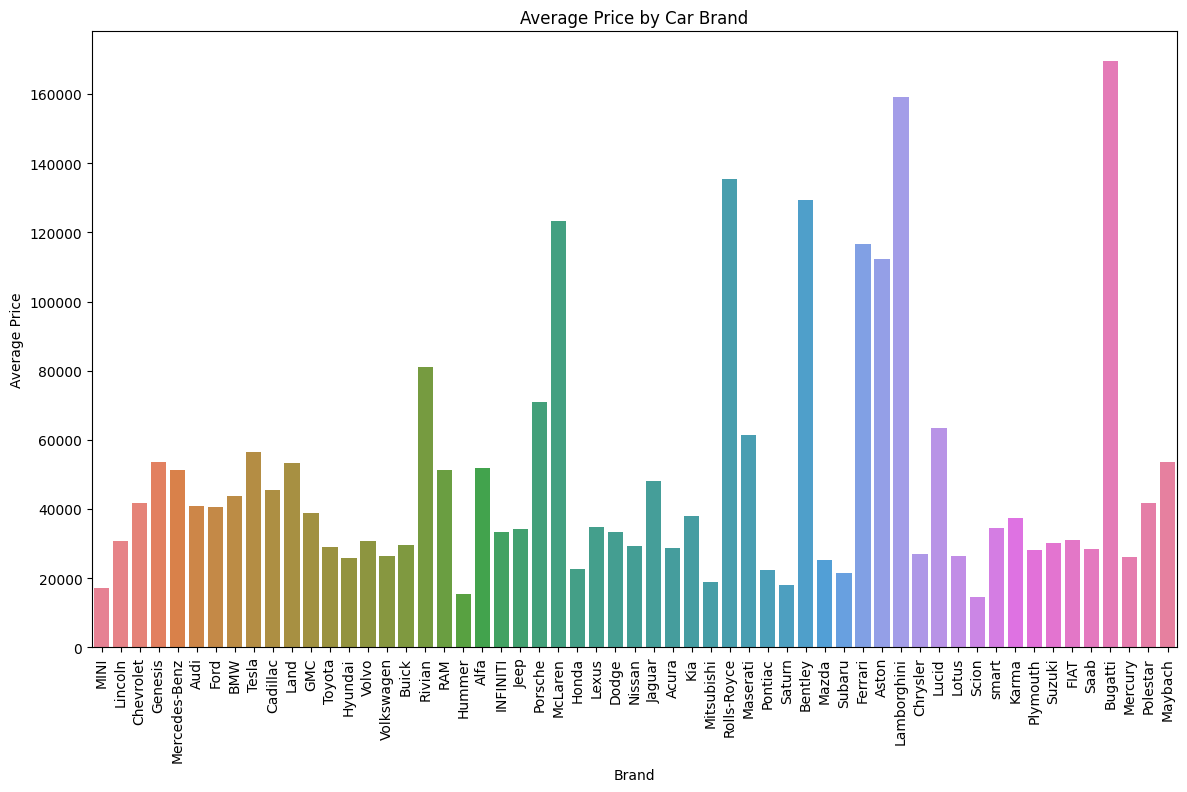

In [8]:
plt.figure(figsize=(14, 8))
sns.barplot(x='brand', y='price', data=data, errorbar=None, hue='brand', legend=False)
plt.title('Average Price by Car Brand')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.xticks(rotation=90)  
plt.show()

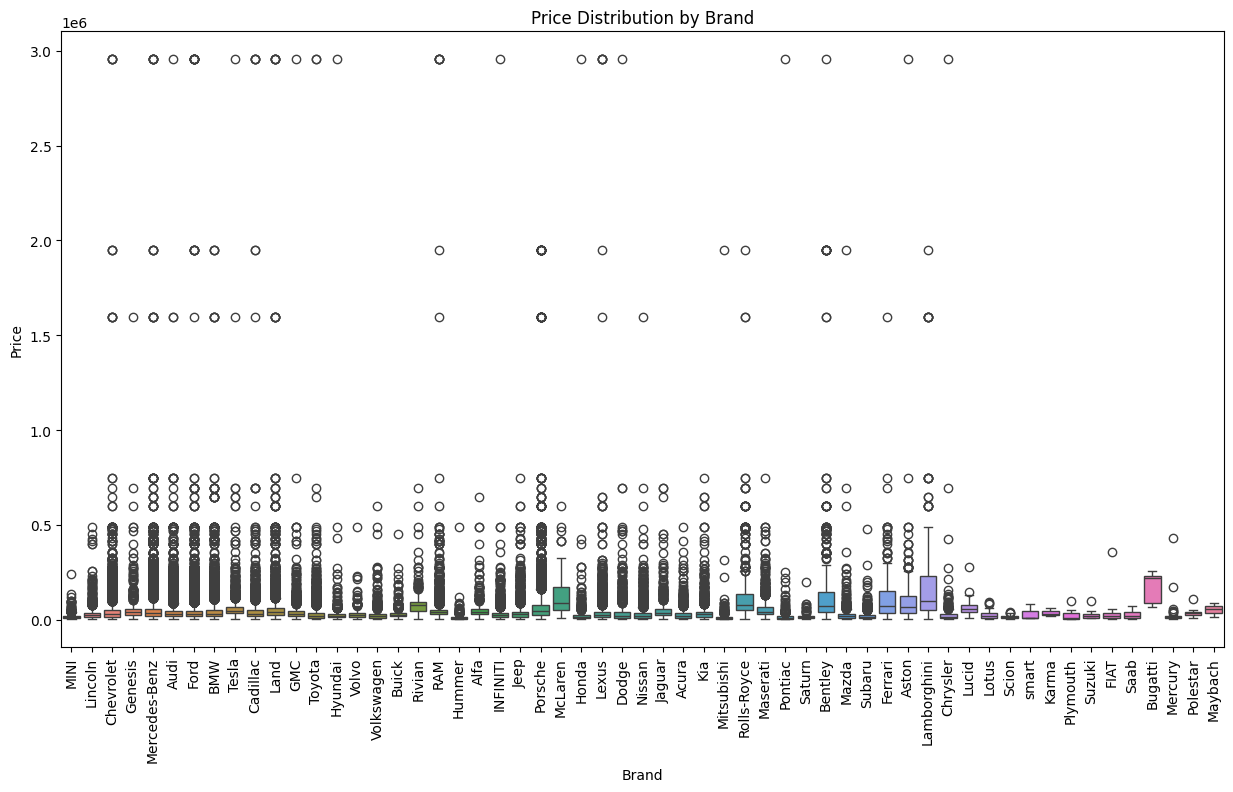

In [9]:
# Box plot for price by car brand
plt.figure(figsize=(15, 8))
sns.boxplot(data=data, x='brand', y='price', hue='brand', legend=False)
plt.xticks(rotation=90)
plt.title("Price Distribution by Brand")
plt.xlabel("Brand")
plt.ylabel("Price")
plt.show()

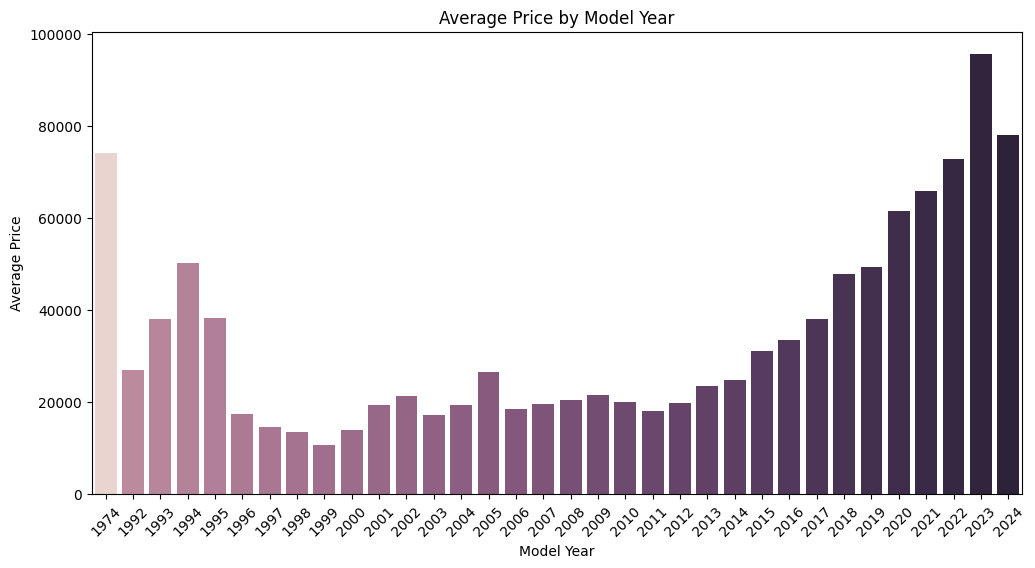

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(x='model_year', y='price', data=data, errorbar=None, hue='model_year', legend=False)
plt.title('Average Price by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

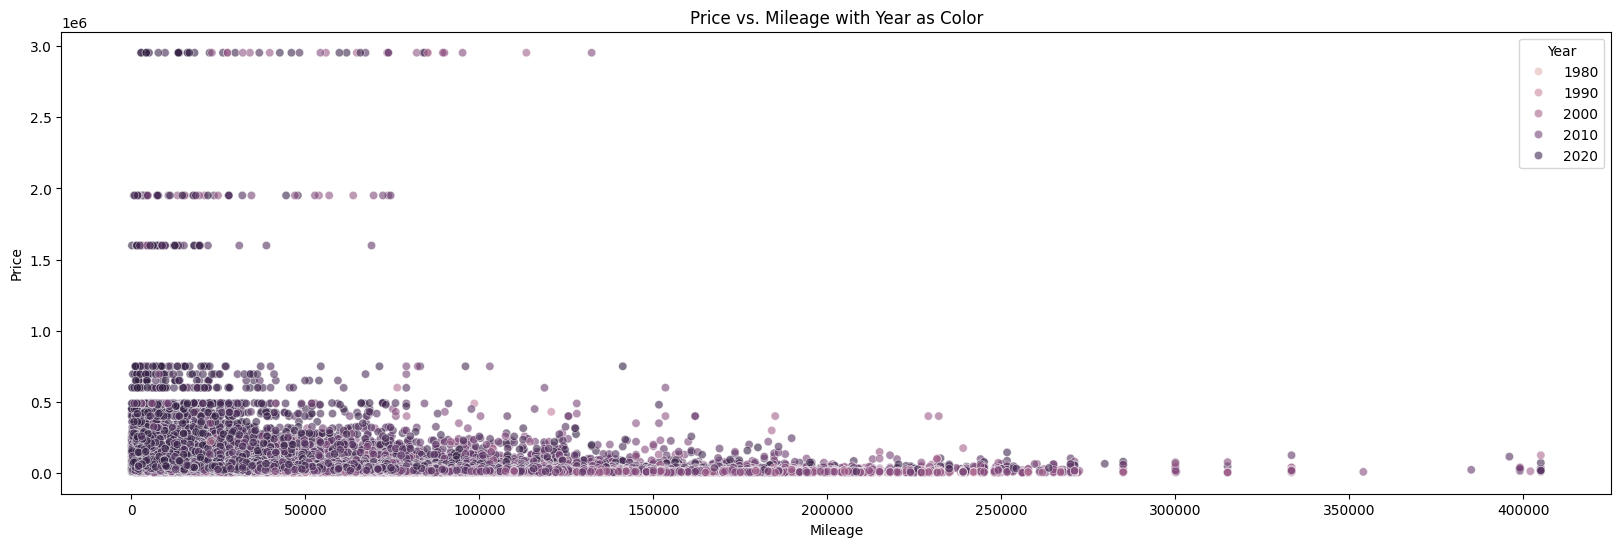

In [11]:
# Scatter plot of Price vs Mileage
plt.figure(figsize=(20, 6))
sns.scatterplot(data=data, x='milage', y='price', hue='model_year', alpha=0.6)
plt.title("Price vs. Mileage with Year as Color")
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.legend(title="Year")
plt.show()

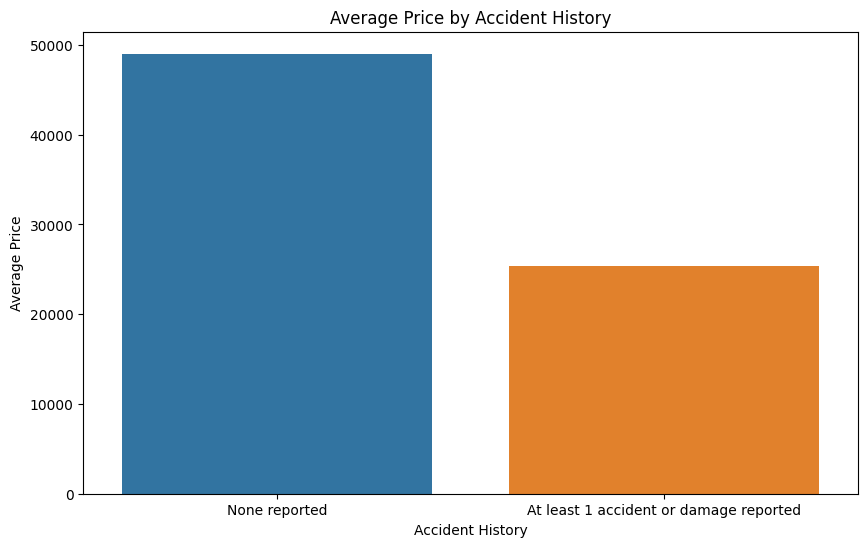

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(x='accident', y='price', data=data, errorbar=None, hue='accident', legend=False)
plt.title('Average Price by Accident History')
plt.xlabel('Accident History')
plt.ylabel('Average Price')
plt.show()

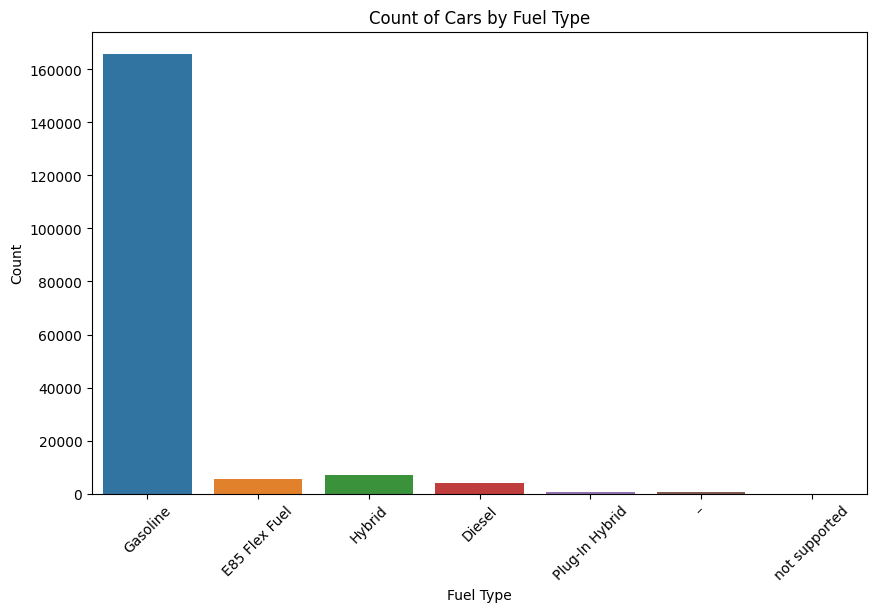

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(x='fuel_type', data=data, hue='fuel_type', legend=False)
plt.title('Count of Cars by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Feature extraction

In [39]:
def vehicle_age(df):
    current_year = 2024

    df['vehicle_age'] = current_year - df['model_year']
    df = df.drop(columns=['model_year'])

    return df

def engine_info(engine_total):
    HP_str = re.search(r'(\d+\.?\d*)HP', engine_total)
    size_str = re.search(r'(\d+\.?\d*)L', engine_total)
    cylinder_str = re.search(r'(\d+) Cylinder', engine_total)

    HP = float(HP_str.group(1)) if HP_str else None
    size = float(size_str.group(1)) if size_str else None
    cylinder = int(cylinder_str.group(1)) if cylinder_str else None

    return HP, size, cylinder

def process_transmission_data(data):
    # Create a DataFrame of unique transmissions
    data_transmission = pd.DataFrame(data['transmission'].unique().tolist(), columns=['Transmission'])
    
    # Feature 1: Extract the number of gears
    data_transmission['speed'] = data_transmission['Transmission'].apply(lambda x: re.search(r'\d+', x).group() if re.search(r'\d+', x) else None)
    
    # Feature 2: Identify transmission type (automatic, manual, CVT)
    data_transmission['transmission_type'] = data_transmission['Transmission'].apply(
        lambda x: 'Automatic' if 'A/T' in x or 'Automatic' in x or 'CVT' in x 
                  else 'Manual' if 'M/T' in x or 'Manual' in x 
                  else 'Other'
    )
    
    # Concatenate the new features with the original data
    data = pd.concat([data, data_transmission[['speed', 'transmission_type']]], axis=1)

    # Drop the "transmission" column
    data = data.drop(columns=['transmission'])
    
    return data

def extract_brand_features(df):
    average_price_per_brand = df.groupby('brand')['price'].mean().reset_index()
    overall_average_price = df['price'].mean()

    # Create brand tier categories (luxury, premium, economy)
    luxury_brands = average_price_per_brand[average_price_per_brand['price'] > (1.5 *overall_average_price)]['brand'].tolist()
    premium_brands = average_price_per_brand[(average_price_per_brand['price'] > (3/4 * overall_average_price)) & (average_price_per_brand['price'] <= (1.5 * overall_average_price))]['brand'].tolist()
    economy_brands = average_price_per_brand[average_price_per_brand['price'] <= (3/4 * overall_average_price)]['brand'].tolist()
    
    df['luxury_brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)
    df['premium_brand'] = df['brand'].apply(lambda x: 1 if x in premium_brands else 0)
    df['economy_brand'] = df['brand'].apply(lambda x: 1 if x in economy_brands else 0)

    df = df.drop(columns=['brand'])
    
    return df

In [40]:
# Add a column "vehicle_age" and drop the column "model_year"
data = vehicle_age(data)
data_test = vehicle_age(data_test)

# Add the columns "HP", "engine_size" and "cylinders" and drop the column "engine"
data[['HP', 'engine_size', 'cylinders']] = data['engine'].apply(lambda x: pd.Series(engine_info(x)))
data_test[['HP', 'engine_size', 'cylinders']] = data_test['engine'].apply(lambda x: pd.Series(engine_info(x)))

data = data.drop(columns=['engine'])
data_test = data_test.drop(columns=['engine'])

# Add the columns "speed" and "transmission_type" and drop the column "transmission"
data = process_transmission_data(data)
data_test = process_transmission_data(data_test)

# Add the columns "luxury_brand", "premium_brand" and "economy_brand" and drop the column "brand"
data = extract_brand_features(data)

In [41]:
data.head()

,id,model,milage,fuel_type,ext_col,int_col,accident,clean_title,price,vehicle_age,HP,engine_size,cylinders,speed,transmission_type,luxury_brand,premium_brand,economy_brand
0,0,Cooper S Base,213000,Gasoline,Yellow,Gray,None reported,Yes,4200,17,172.0,1.6,4.0,None,Automatic,0,0,1
1,1,LS V8,143250,Gasoline,Silver,Beige,At least 1 accident or damage reported,Yes,4999,22,252.0,3.9,8.0,None,Other,0,0,1
2,2,Silverado 2500 LT,136731,E85 Flex Fuel,Blue,Gray,None reported,Yes,13900,22,320.0,5.3,8.0,7,Automatic,0,1,0
3,3,G90 5.0 Ultimate,19500,Gasoline,Black,Black,None reported,Yes,45000,7,420.0,5.0,8.0,8,Automatic,0,1,0
4,4,Metris Base,7388,Gasoline,Black,Beige,None reported,Yes,97500,3,208.0,2.0,4.0,10,Automatic,0,1,0


In [42]:
# Replace '-' with 'Electric' in the "fuel_type" because electric is mentioned in the "Data card" of the dataset and it is not in the values, so it must be the '-'
print('Fuel types pre processing:', data['fuel_type'].unique())
data['fuel_type'] = data['fuel_type'].fillna('Unknown')
data['fuel_type'] = data['fuel_type'].replace('–', 'Electric')
print('Fuel types post processing:', data['fuel_type'].unique())

data_test['fuel_type'] = data_test['fuel_type'].fillna('Unknown')
data_test['fuel_type'] = data_test['fuel_type'].replace('–', 'Electric')

print()

# Accidents
print('Accidents pre processing:', data['accident'].unique())
data['accident'] = data['accident'].fillna('Unknown')
print('Accidents post processing:', data['accident'].unique())
data_test['accident'] = data_test['accident'].fillna('Unknown')

print()

# Clean title
print('Clean title pre processing:', data['clean_title'].unique())
data['clean_title'] = data['clean_title'].fillna('Unknown')
print('Clean title post processing:', data['clean_title'].unique())
data_test['clean_title'] = data_test['clean_title'].fillna('Unknown')

print()

# HP
print('HP pre processing:', data['HP'].unique())
data['HP'] = data['HP'].fillna(0)
print('HP processing', data['HP'].unique())
data_test['HP'] = data_test['HP'].fillna(0)

print()

# Engine size
print('Engine size pre processing:', data['engine_size'].unique())
data['engine_size'] = data['engine_size'].fillna(0)
print('Engine size processing', data['engine_size'].unique())
data_test['engine_size'] = data_test['engine_size'].fillna(0)

print()

# Cylinders
print('Cylinders pre processing:', data['cylinders'].unique())
data['cylinders'] = data['cylinders'].fillna(0)
print('Cylinders processing', data['cylinders'].unique())
data_test['cylinders'] = data_test['cylinders'].fillna(0)

print()

# Speed
print('Speed pre processing:', data['speed'].unique())
data['speed'] = data['speed'].fillna('0')
print('Speed post processing', data['speed'].unique())
data_test['speed'] = data_test['speed'].fillna('0')

print()

# Transmission type
print('Transmission type pre processing:', data['transmission_type'].unique())
data['transmission_type'] = data['transmission_type'].fillna('Unknown')
print('Transmission type post processing', data['transmission_type'].unique())
data_test['transmission_type'] = data_test['transmission_type'].fillna('Unknown')

Fuel types pre processing: ['Gasoline' 'E85 Flex Fuel' nan 'Hybrid' 'Diesel' 'Plug-In Hybrid' '–'
 'not supported']
Fuel types post processing: ['Gasoline' 'E85 Flex Fuel' 'Unknown' 'Hybrid' 'Diesel' 'Plug-In Hybrid'
 'Electric' 'not supported']

Accidents pre processing: ['None reported' 'At least 1 accident or damage reported' nan]
Accidents post processing: ['None reported' 'At least 1 accident or damage reported' 'Unknown']

Clean title pre processing: ['Yes' nan]
Clean title post processing: ['Yes' 'Unknown']

HP pre processing: [ 172.  252.  320.  420.  208.  333.  355.   nan  425.  312.  523.  503.
  395.  310.  469.  429.  210.  335.  316.  381.  450.  236.  211.  220.
  255.  518.  268.  174.  240.  248.  563.  241.  230.  430.  835.  300.
  280.  295.  348.  560.  285.  302.  490.  200.  416.  179.  385.  160.
  270.  350.  190.  181.  265.  345.  400.  261.  536.  402.  382.  180.
  617.  173.  389.  318.  325.  365.  340.  235.  169.  710.  225.  366.
  284.  260.  670.  48

In [43]:
print('TRAIN SET:')
print(data.isnull().sum())
print('\nTEST SET:')
print(data_test.isnull().sum())

TRAIN SET:
id                   0
model                0
milage               0
fuel_type            0
ext_col              0
int_col              0
accident             0
clean_title          0
price                0
vehicle_age          0
HP                   0
engine_size          0
cylinders            0
speed                0
transmission_type    0
luxury_brand         0
premium_brand        0
economy_brand        0
dtype: int64

TEST SET:
id                   0
brand                0
model                0
milage               0
fuel_type            0
ext_col              0
int_col              0
accident             0
clean_title          0
vehicle_age          0
HP                   0
engine_size          0
cylinders            0
speed                0
transmission_type    0
dtype: int64


In [44]:
# drop columns that I think that are not useful (the color of the car can be changed and usually it is a cheap optional)
data = data.drop(columns=['id', 'clean_title', 'ext_col', 'int_col', 'model'])

In [45]:
data.head()

,milage,fuel_type,accident,price,vehicle_age,HP,engine_size,cylinders,speed,transmission_type,luxury_brand,premium_brand,economy_brand
0,213000,Gasoline,None reported,4200,17,172.0,1.6,4.0,0,Automatic,0,0,1
1,143250,Gasoline,At least 1 accident or damage reported,4999,22,252.0,3.9,8.0,0,Other,0,0,1
2,136731,E85 Flex Fuel,None reported,13900,22,320.0,5.3,8.0,7,Automatic,0,1,0
3,19500,Gasoline,None reported,45000,7,420.0,5.0,8.0,8,Automatic,0,1,0
4,7388,Gasoline,None reported,97500,3,208.0,2.0,4.0,10,Automatic,0,1,0


## Encode the non-numerical features

In [46]:
# Encode the accident column as 1 if 'At least 1 accident or damage reported', else 0
data['accident'] = data['accident'].apply(lambda x: 1 if x=='At least 1 accident or damage reported' else 0)
data_test['accident'] = data_test['accident'].apply(lambda x: 1 if x=='At least 1 accident or damage reported' else 0)

In [47]:
# Transform the column 'speed' to numerical data, it was a column of strings before
data['speed'] = data['speed'].replace('Unknown', 0)
data['speed'] = pd.to_numeric(data['speed'])

data_test['speed'] = data_test['speed'].replace('Unknown', 0)
data_test['speed'] = pd.to_numeric(data_test['speed'])

In [48]:
# Encode the 'transmission_type' as 1 if it is 'Automatic', 0 if it is 'Manual' or else
data['transmission_type'] = data['transmission_type'].apply(lambda x: 1 if x=='Automatic' else 0)
data_test['transmission_type'] = data_test['transmission_type'].apply(lambda x: 1 if x=='Automatic' else 0)

In [50]:
columns_to_standardize = ['milage', 'vehicle_age', 'HP', 'engine_size']

scaler = StandardScaler()
data[columns_to_standardize] = scaler.fit_transform(data[columns_to_standardize])
data_test[columns_to_standardize] = scaler.fit_transform(data_test[columns_to_standardize])

In [51]:
for col in columns_to_standardize:
    scaler = MinMaxScaler()
    data[col] = scaler.fit_transform(data[[col]])

In [52]:
data.head()

,milage,fuel_type,accident,price,vehicle_age,HP,engine_size,cylinders,speed,transmission_type,luxury_brand,premium_brand,economy_brand
0,0.525809,Gasoline,0,4200,0.34,0.168627,0.190476,4.0,0,1,0,0,1
1,0.353544,Gasoline,1,4999,0.44,0.247059,0.464286,8.0,0,0,0,0,1
2,0.337444,E85 Flex Fuel,0,13900,0.44,0.313725,0.630952,8.0,7,1,0,1,0
3,0.047913,Gasoline,0,45000,0.14,0.411765,0.595238,8.0,8,1,0,1,0
4,0.018000,Gasoline,0,97500,0.06,0.203922,0.238095,4.0,10,1,0,1,0


In [53]:
categorical_columns = ['fuel_type']

data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
data_test_encoded = pd.get_dummies(data_test, columns=categorical_columns, drop_first=True)


# Replace True with 1 and False with 0
data_encoded = data_encoded.replace({True: 1, False: 0})
data_test_encoded = data_test_encoded.replace({True: 1, False: 0})

/var/folders/_g/7s4z636d67z67rlmmnqgx5mm0000gn/T/ipykernel_11364/2011626096.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data_encoded.replace({True: 1, False: 0})
/var/folders/_g/7s4z636d67z67rlmmnqgx5mm0000gn/T/ipykernel_11364/2011626096.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_test_encoded = data_test_encoded.replace({True: 1, False: 0})


In [54]:
data_encoded.head()

,milage,accident,price,vehicle_age,HP,engine_size,cylinders,speed,transmission_type,luxury_brand,premium_brand,economy_brand,fuel_type_E85 Flex Fuel,fuel_type_Electric,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,fuel_type_Unknown,fuel_type_not supported
0,0.525809,0,4200,0.34,0.168627,0.190476,4.0,0,1,0,0,1,0,0,1,0,0,0,0
1,0.353544,1,4999,0.44,0.247059,0.464286,8.0,0,0,0,0,1,0,0,1,0,0,0,0
2,0.337444,0,13900,0.44,0.313725,0.630952,8.0,7,1,0,1,0,1,0,0,0,0,0,0
3,0.047913,0,45000,0.14,0.411765,0.595238,8.0,8,1,0,1,0,0,0,1,0,0,0,0
4,0.018000,0,97500,0.06,0.203922,0.238095,4.0,10,1,0,1,0,0,0,1,0,0,0,0


In [55]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   milage                    188533 non-null  float64
 1   accident                  188533 non-null  int64  
 2   price                     188533 non-null  int64  
 3   vehicle_age               188533 non-null  float64
 4   HP                        188533 non-null  float64
 5   engine_size               188533 non-null  float64
 6   cylinders                 188533 non-null  float64
 7   speed                     188533 non-null  int64  
 8   transmission_type         188533 non-null  int64  
 9   luxury_brand              188533 non-null  int64  
 10  premium_brand             188533 non-null  int64  
 11  economy_brand             188533 non-null  int64  
 12  fuel_type_E85 Flex Fuel   188533 non-null  int64  
 13  fuel_type_Electric        188533 non-null  i

## Create X_train and y_train

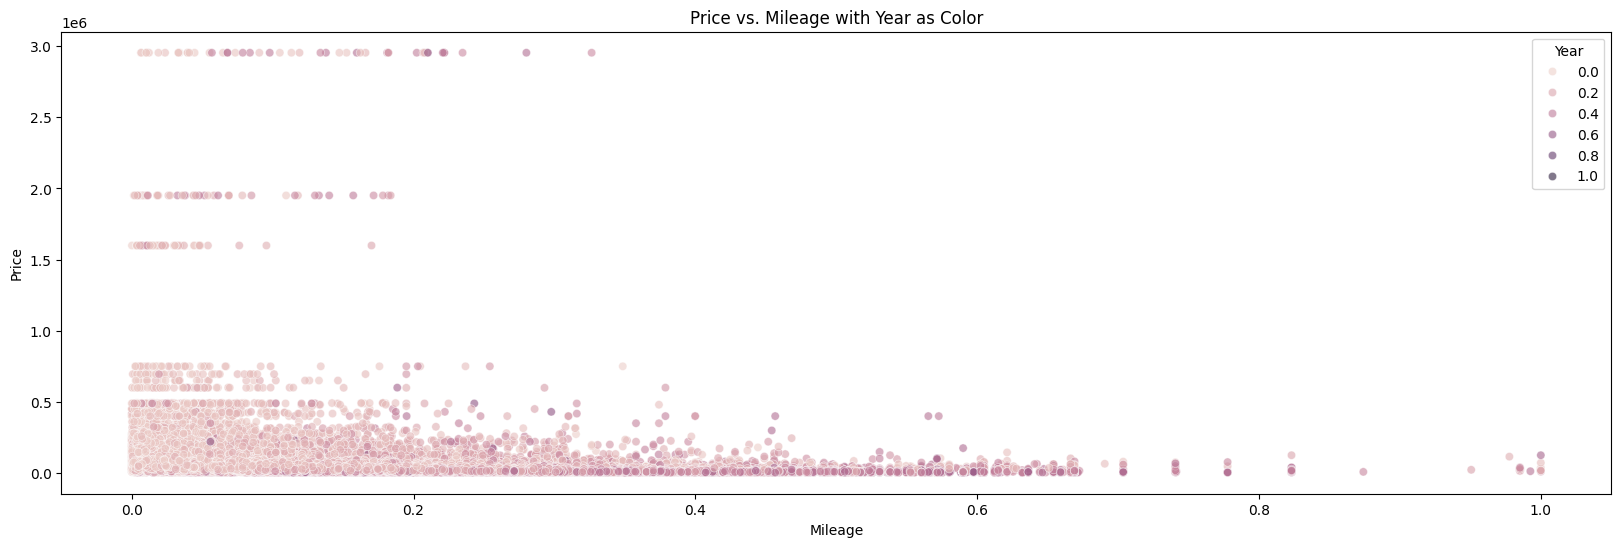

In [56]:
# Scatter plot of Price vs Mileage
plt.figure(figsize=(20, 6))
sns.scatterplot(data=data_encoded, x='milage', y='price', hue='vehicle_age', alpha=0.6)
plt.title("Price vs. Mileage with Year as Color")
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.legend(title="Year")
plt.show()

In [57]:
X = data_encoded.drop(columns=['price'])
y = data_encoded['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_test_final = data_test_encoded

## Create, train and evaluate model

In [58]:

def plot_results(train_rmse, test_rmse, ytrain, ytest, ytrainpred, ytestpred):
    rmse_values = [train_rmse, test_rmse]
    labels = ['Train RMSE', 'Test RMSE']

    # Plot RMSE Comparison
    plt.figure(figsize=(8, 5))
    plt.bar(labels, rmse_values, color=['blue', 'orange'])
    plt.ylabel('RMSE')
    plt.title('RMSE Comparison')
    plt.show()

    # Plot Predictions vs True Values for Training and Testing sets separately
    # Determine the y-axis limits for training and test sets
    train_ylim = (min(min(ytrain), min(ytrainpred)), max(max(ytrain), max(ytrainpred)))
    test_ylim = (min(min(ytest), min(ytestpred)), max(max(ytest), max(ytestpred)))

    plt.figure(figsize=(14, 10))

    # 1. Training Set True Values
    plt.subplot(2, 2, 1)
    plt.plot(range(len(ytrain)), ytrain, 'o', color='blue', markersize=5, label='True Values')
    plt.xlabel('Element')
    plt.ylabel('Value')
    plt.title('Training Set: True Values')
    plt.ylim(train_ylim)  # Set y-axis limits for training
    plt.grid()
    plt.legend()

    # 2. Training Set Predicted Values
    plt.subplot(2, 2, 2)
    plt.plot(range(len(ytrainpred)), ytrainpred, 'o', color='red', markersize=5, label='Predicted Values')
    plt.xlabel('Element')
    plt.ylabel('Value')
    plt.title('Training Set: Predicted Values')
    plt.ylim(train_ylim)  # Set y-axis limits for training
    plt.grid()
    plt.legend()

    # 3. Test Set True Values
    plt.subplot(2, 2, 3)
    plt.plot(range(len(ytest)), ytest, 'o', color='blue', markersize=5, label='True Values')
    plt.xlabel('Element')
    plt.ylabel('Value')
    plt.title('Test Set: True Values')
    plt.ylim(test_ylim)  # Set y-axis limits for test
    plt.grid()
    plt.legend()

    # 4. Test Set Predicted Values
    plt.subplot(2, 2, 4)
    plt.plot(range(len(ytestpred)), ytestpred, 'o', color='red', markersize=5, label='Predicted Values')
    plt.xlabel('Element')
    plt.ylabel('Value')
    plt.title('Test Set: Predicted Values')
    plt.ylim(test_ylim)  # Set y-axis limits for test
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

In [59]:
# prepare a dataframe for the quality results
results = pd.DataFrame(columns=['Model','Train RMSE','Test RMSE'])

Train rmse 75500.9152788129
Test rmse 69895.76622274269


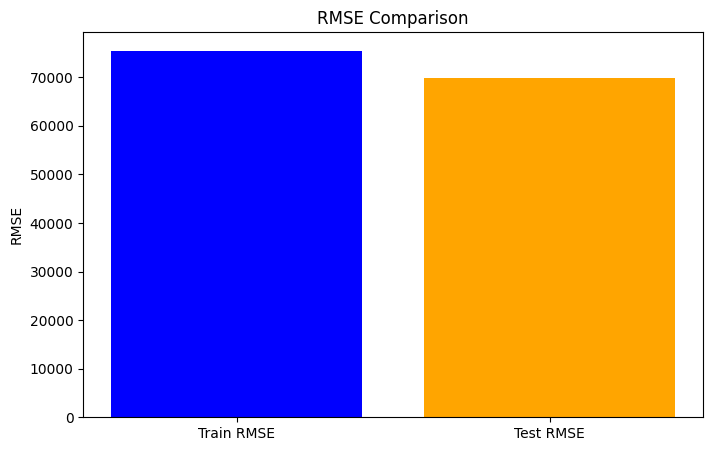

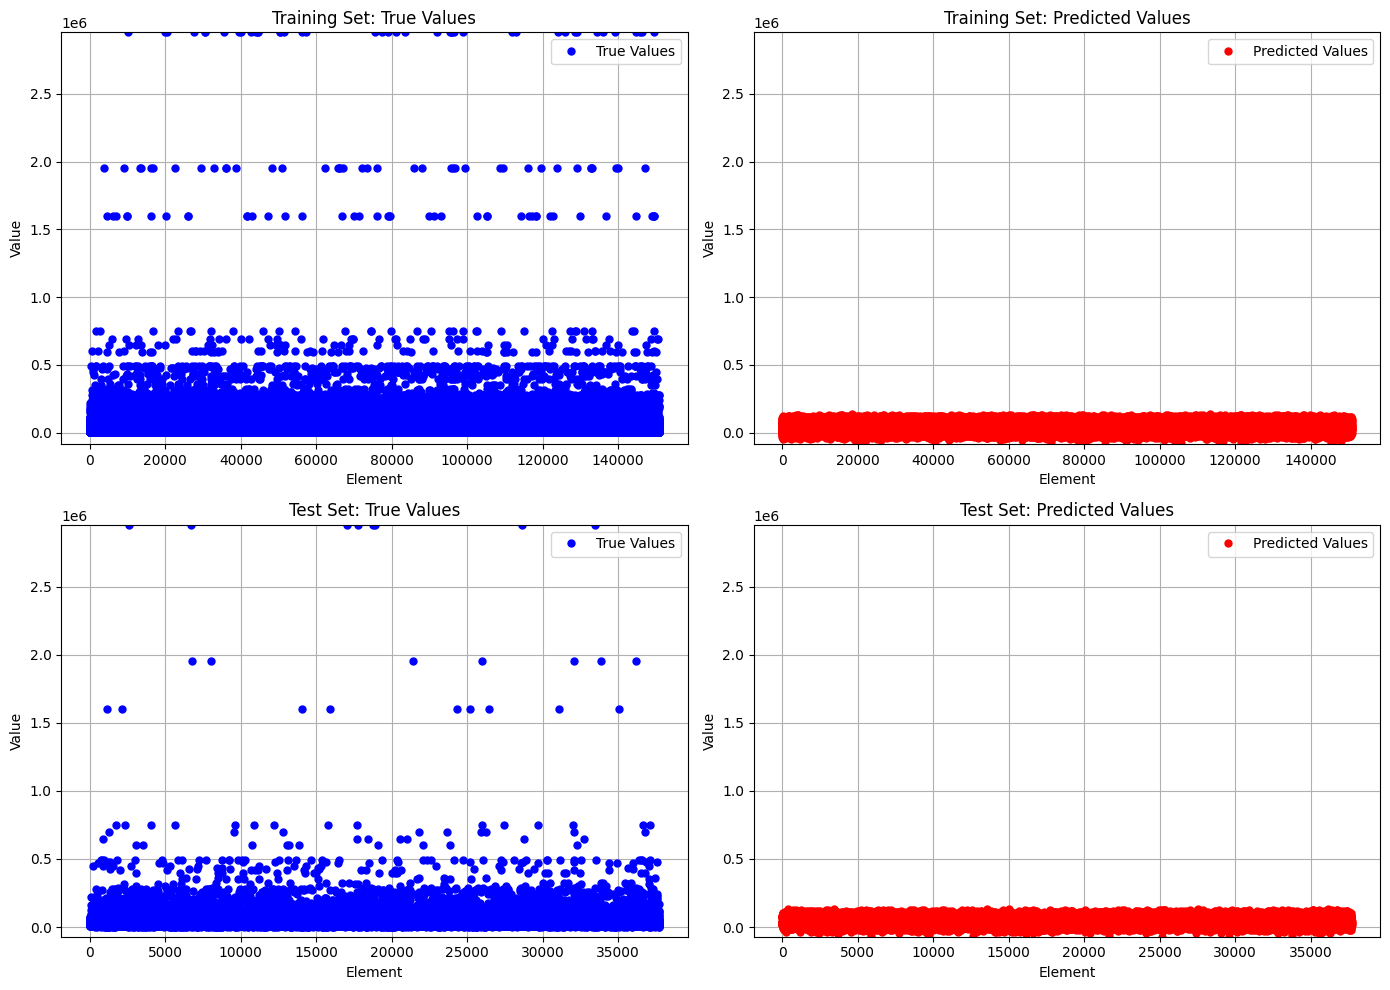

In [60]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

train_y_pred_lr = lr.predict(X_train)
train_rmse_lr = root_mean_squared_error(train_y_pred_lr, y_train)
print('Train rmse', train_rmse_lr)

test_y_pred_lr = lr.predict(X_test)
test_rmse_lr = root_mean_squared_error(test_y_pred_lr, y_test)
print('Test rmse', test_rmse_lr)

results.loc[len(results)] = ['Linear Regressor', train_rmse_lr, test_rmse_lr]

plot_results(train_rmse_lr, test_rmse_lr, y_train, y_test, train_y_pred_lr, test_y_pred_lr)

Train rmse 40277.35953978832
Test rmse 74850.15849727714


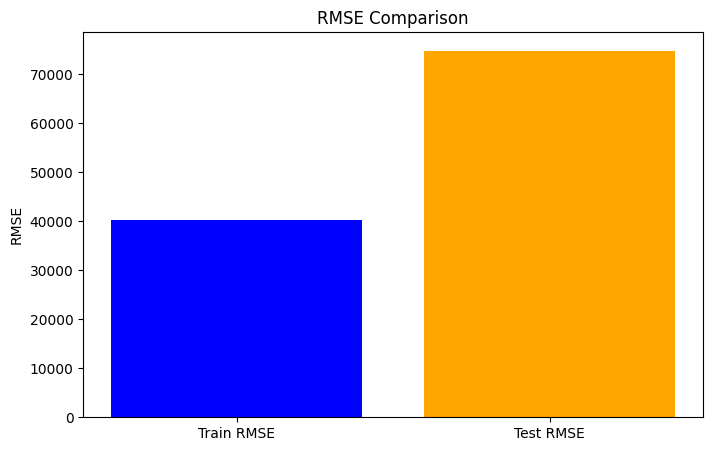

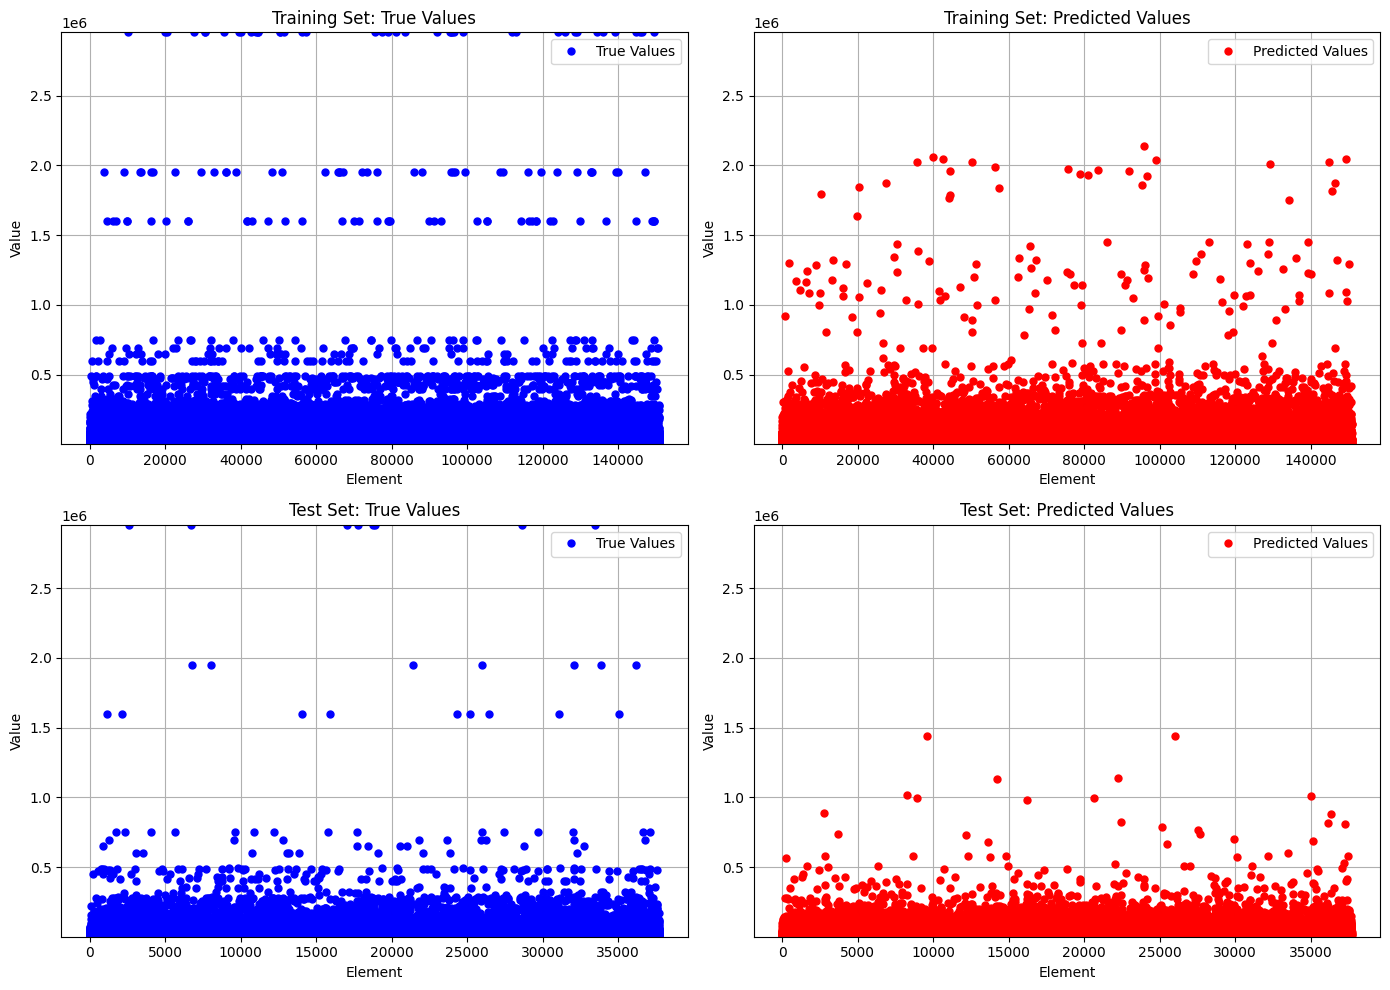

In [61]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=random_state)
rf.fit(X_train, y_train)

train_y_pred_rf = rf.predict(X_train)
train_rmse_rf = root_mean_squared_error(train_y_pred_rf, y_train)
print('Train rmse', train_rmse_rf)

test_y_pred_rf = rf.predict(X_test)
test_rmse_rf = root_mean_squared_error(test_y_pred_rf, y_test)
print('Test rmse', test_rmse_rf)

results.loc[len(results)] = ['Random Forest Regressor', train_rmse_rf, test_rmse_rf]

plot_results(train_rmse_rf, test_rmse_rf, y_train, y_test, train_y_pred_rf, test_y_pred_rf)

In [66]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train, y_train)

train_y_pred_svr = svr.predict(X_train)
train_rmse_svr = root_mean_squared_error(train_y_pred_svr, y_train)
print('Train rmse', train_rmse_svr)

test_y_pred_svr = svr.predict(X_test)
test_rmse_svr = root_mean_squared_error(test_y_pred_svr, y_test)
print('Test rmse', test_rmse_svr)

results.loc[len(results)] = ['Linear Regressor', train_rmse_svr, test_rmse_svr]

plot_results(train_rmse_svr, test_rmse_svr, y_train, y_test, train_y_pred_svr, test_y_pred_svr)

Train rmse 79694.25124143412
Test rmse 76619.86494786783


Best parameters found: {'max_depth': 10, 'n_estimators': 200}
Train rmse 61760.61581009444
Test rmse 69473.44686950144


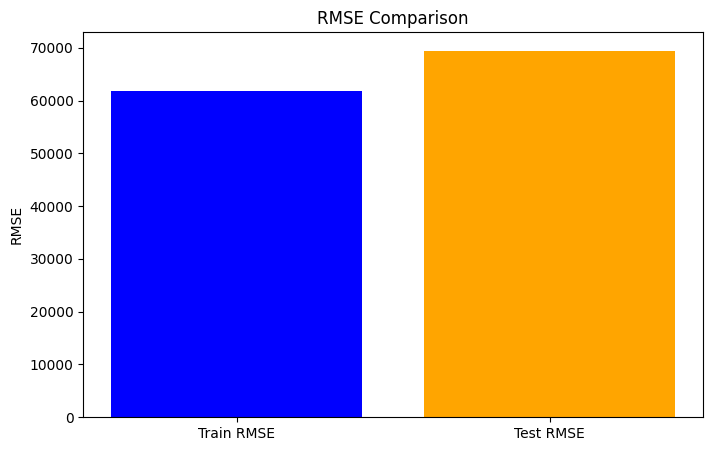

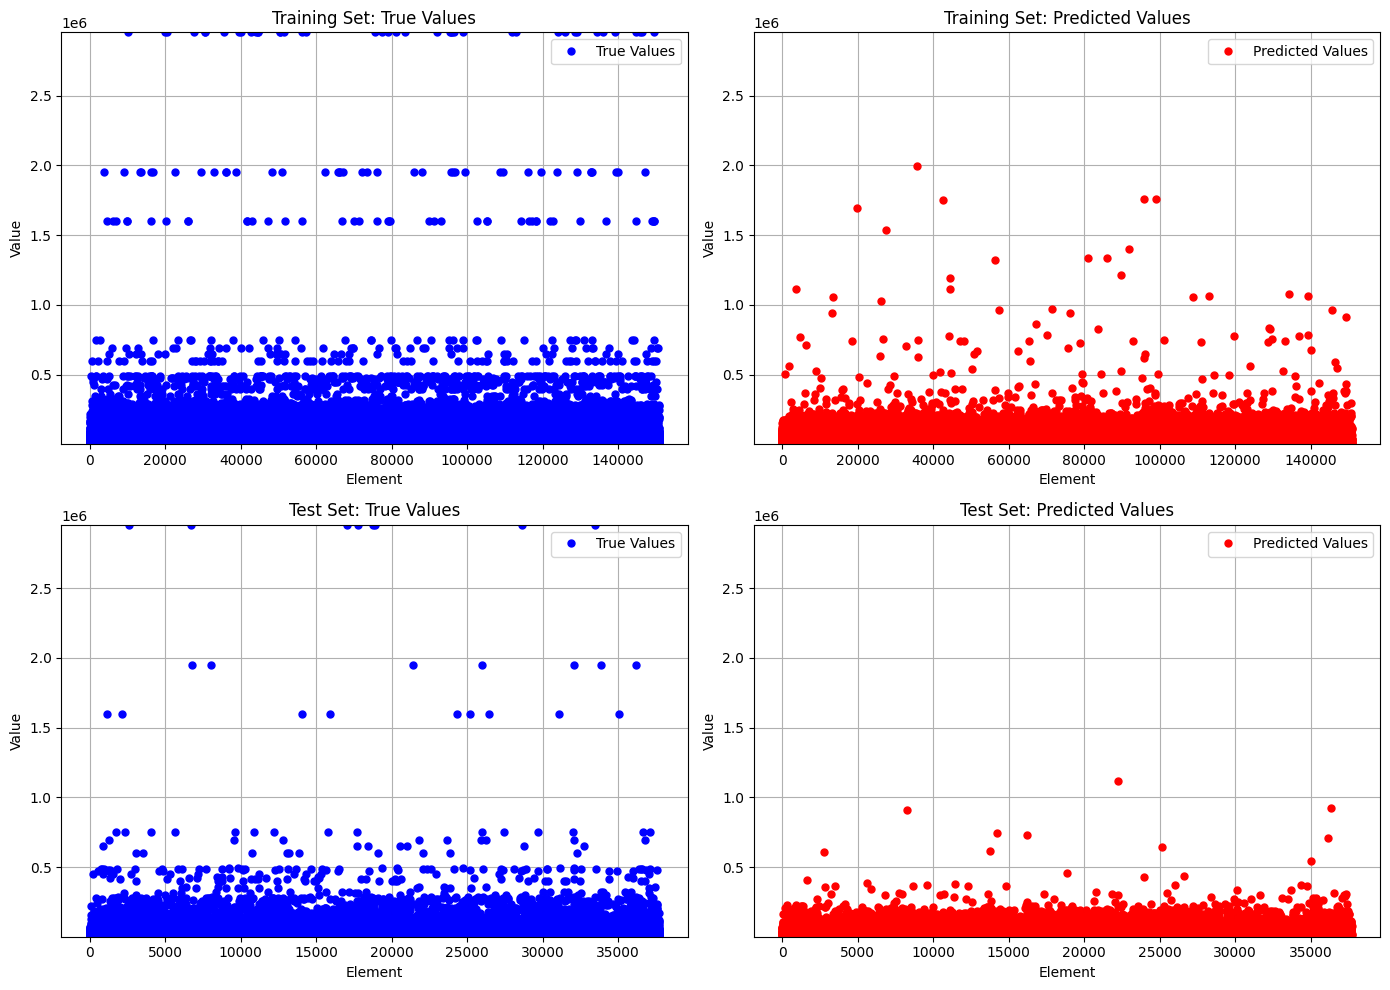

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_regr = RandomForestRegressor()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200], # [50, 100, 200],   # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    #'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    #'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required at a leaf node       # Whether bootstrap samples are used when building trees
}

# Initialize GridSearchCV with RandomForestRegressor and param_grid
grid_search = GridSearchCV(estimator=rf_regr, param_grid=param_grid,
                           cv=5, scoring='neg_root_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters found: {grid_search.best_params_}")

# Predict on the training set
y_pred_train_rfgs = grid_search.predict(X_train)
train_rmse_rfgs = root_mean_squared_error(y_pred_train_rfgs, y_train)
print('Train rmse', train_rmse_rfgs)


# # Predict on the test set
y_pred_test_rfgs = grid_search.predict(X_test)
test_rmse_rfgs = root_mean_squared_error(y_test, y_pred_test_rfgs)
print('Test rmse', test_rmse_rfgs)

results.loc[len(results)] = ['Random Forest Regressor GS', train_rmse_rfgs, test_rmse_rfgs]

plot_results(train_rmse_rfgs, test_rmse_rfgs, y_train, y_test, y_pred_train_rfgs, y_pred_test_rfgs)

Train rmse 41445.33719421372
Test rmse 77550.0899234846


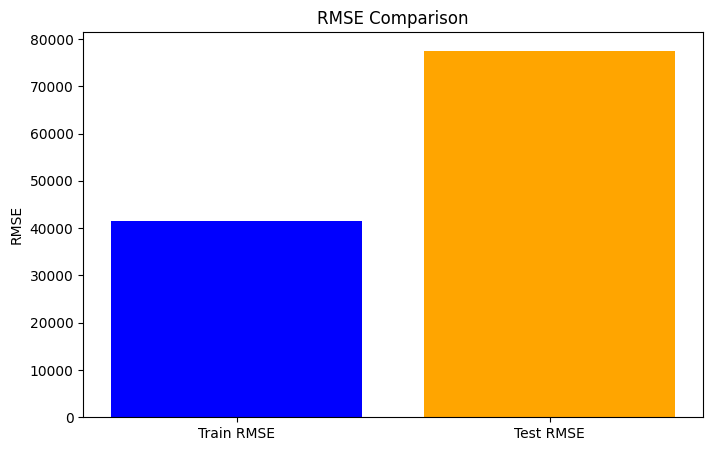

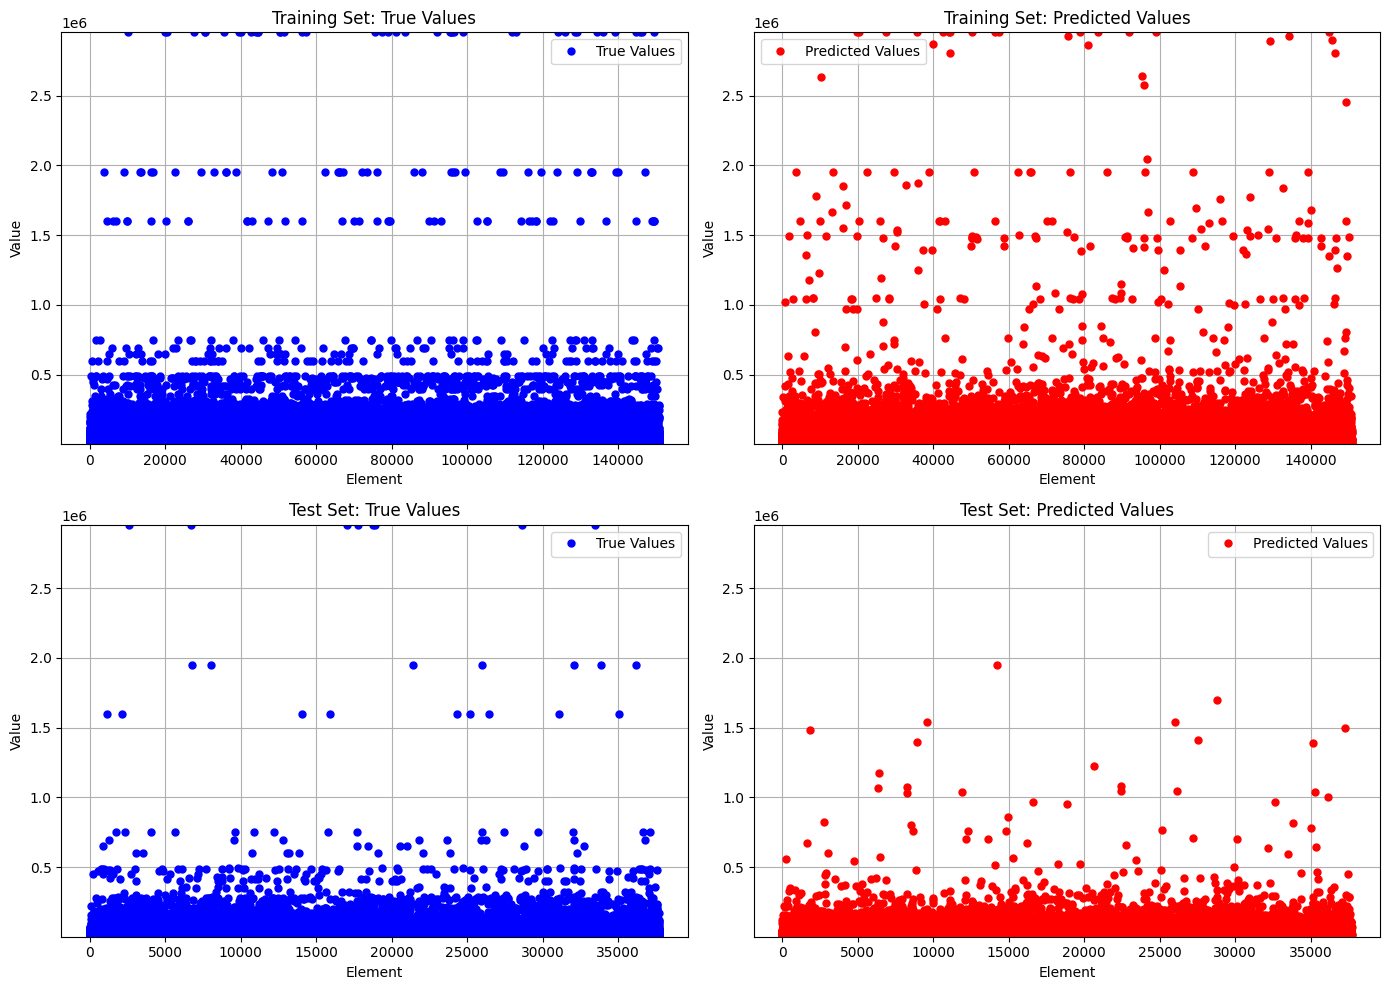

In [66]:
from sklearn.ensemble import AdaBoostRegressor

ab = AdaBoostRegressor(estimator=rf, n_estimators=10, random_state=random_state)
ab.fit(X_train, y_train)

train_y_pred_ab = ab.predict(X_train)
train_rmse_ab = root_mean_squared_error(train_y_pred_ab, y_train)
print('Train rmse', train_rmse_ab)

test_y_pred_ab = ab.predict(X_test)
test_rmse_ab = root_mean_squared_error(test_y_pred_ab, y_test)
print('Test rmse', test_rmse_ab)

results.loc[len(results)] = ['AdaBoost Regressor', train_rmse_ab, test_rmse_ab]

plot_results(train_rmse_ab, test_rmse_ab, y_train, y_test, train_y_pred_ab, test_y_pred_ab)

Train rmse 72930.09494486042
Test rmse 68756.1804617185


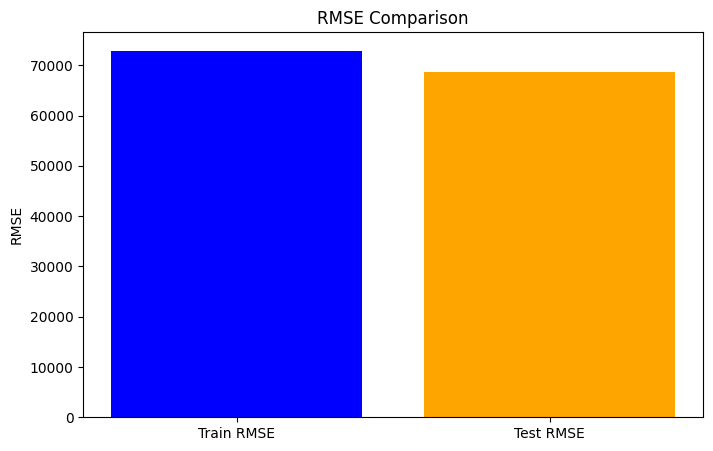

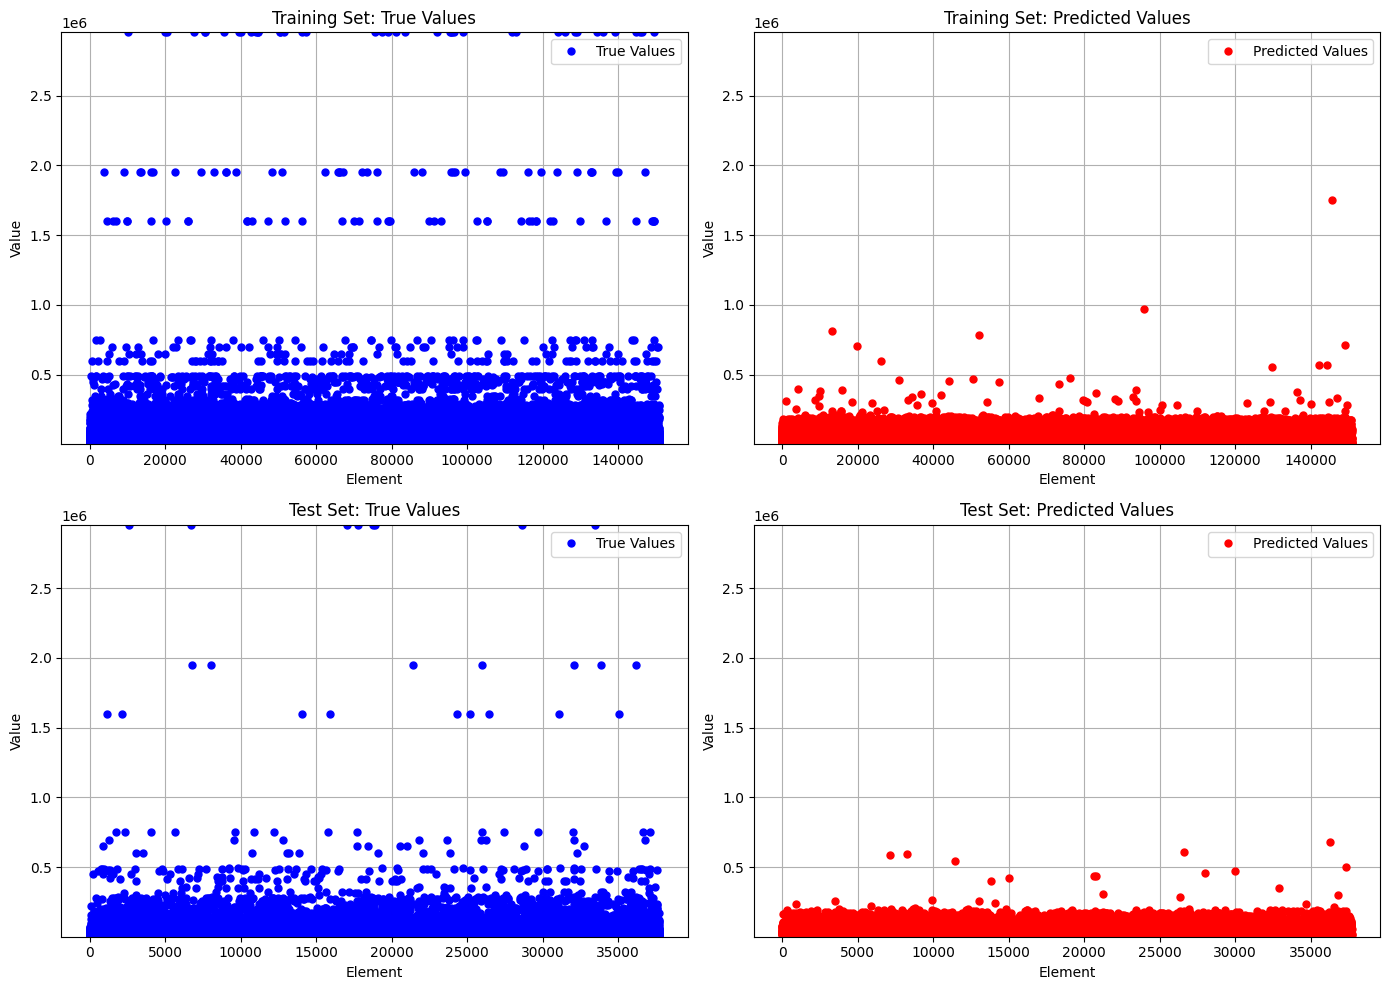

In [63]:
from sklearn.neural_network import MLPRegressor

mlpr = MLPRegressor(random_state=random_state, 
                    hidden_layer_sizes=(128, 256, 512, 256, 128), 
                    max_iter=1000, 
                    learning_rate='adaptive')

mlpr.fit(X_train, y_train)

train_y_pred_mlpr = mlpr.predict(X_train)
train_rmse_mlpr = root_mean_squared_error(train_y_pred_mlpr, y_train)
print('Train rmse', train_rmse_mlpr)

test_y_pred_mlpr = mlpr.predict(X_test)
test_rmse_mlpr = root_mean_squared_error(test_y_pred_mlpr, y_test)
print('Test rmse', test_rmse_mlpr)

results.loc[len(results)] = ['MLP Regressor', train_rmse_mlpr, test_rmse_mlpr]

plot_results(train_rmse_mlpr, test_rmse_mlpr, y_train, y_test, train_y_pred_mlpr, test_y_pred_mlpr)

In [69]:
results.style.format(precision=0)

,Model,Train RMSE,Test RMSE
0,Linear Regressor,75501,69896
1,Random Forest Regressor,40277,74850
2,AdaBoost Regressor,75083,69430
3,MLP Regressor,72930,68756
4,AdaBoost Regressor,41445,77550
5,Random Forest Regressor GS,61761,69473
